# <center> NN-VQE
Here, we take multiparameter Hamiltonians.

## Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorcircuit as tc
import cotengra
import quimb
from tqdm.notebook import tqdm
from functools import partial

optc = cotengra.ReusableHyperOptimizer(
    methods=["greedy"],
    parallel="ray",
    minimize="combo",
    max_time=30,
    max_repeats=1024,
    progbar=True,
)
tc.set_contractor("custom", optimizer=optc, preprocessing=True)

K = tc.set_backend("tensorflow")
tc.set_dtype("complex128")

## Energy

We use 2-parameter 1D XXZ model. Here, both the anisotropy parameter $\Delta$ and the transverse field strength $\lambda$ are tunable.

$$ \hat{H}_{XXZ}=\sum_{i}{X_{i}X_{i+1}+Y_{i}Y_{i+1}+\Delta Z_{i}Z_{i+1}} + \lambda \sum_{i}{Z_{i}} $$

In [2]:
def energy(c: tc.Circuit, delta: float = 1.0, lamb: float = 1.0):
    e = 0.0
    n = c._nqubits
    for i in range(n):
        e += lamb * c.expectation((tc.gates.z(), [i]))  # <Z_i>
    for i in range(n):
        e += c.expectation(
            (tc.gates.x(), [i]), (tc.gates.x(), [(i + 1) % n])
        )  # <X_i X_{i+1}>
        e += c.expectation(
            (tc.gates.y(), [i]), (tc.gates.y(), [(i + 1) % n])
        )  # <Y_i Y_{i+1}>
        e += delta * c.expectation(
            (tc.gates.z(), [i]), (tc.gates.z(), [(i + 1) % n])
        )  # <Z_i Z_{i+1}>
    return K.real(e)

## VQE circuit

In [4]:
# ladder
def VQE(inp, n, d=1, energy_flag=False):
    params = K.cast(inp["params"], "complex128")
    delta = K.cast(inp["delta"], "complex128")  # 1st Hamiltonian parameter
    lamb = K.cast(inp["lamb"], "complex128")  # 2nd Hamiltonian parameter

    c = tc.Circuit(n)

    idx = 0

    for i in range(n):
        c.rx(i, theta=params[3 * i])
        c.rz(i, theta=params[3 * i + 1])
        c.rx(i, theta=params[3 * i + 2])
    idx += 3 * n

    for _ in range(d):
        for i in range(0, n):
            c.rzz(i, (i + 1) % n, theta=params[idx])
        idx += n

        for i in range(0, n):
            c.rxx(i, (i + 1) % n, theta=params[idx])
        idx += n

        for i in range(0, n):
            c.ryy(i, (i + 1) % n, theta=params[idx])
        idx += n

        for i in range(n):
            c.rx(i, theta=params[idx])
            c.rz(i, theta=params[idx + 1])
        idx += 2 * n

    if energy_flag:
        return energy(c, delta, lamb)
    else:
        return c, idx

104


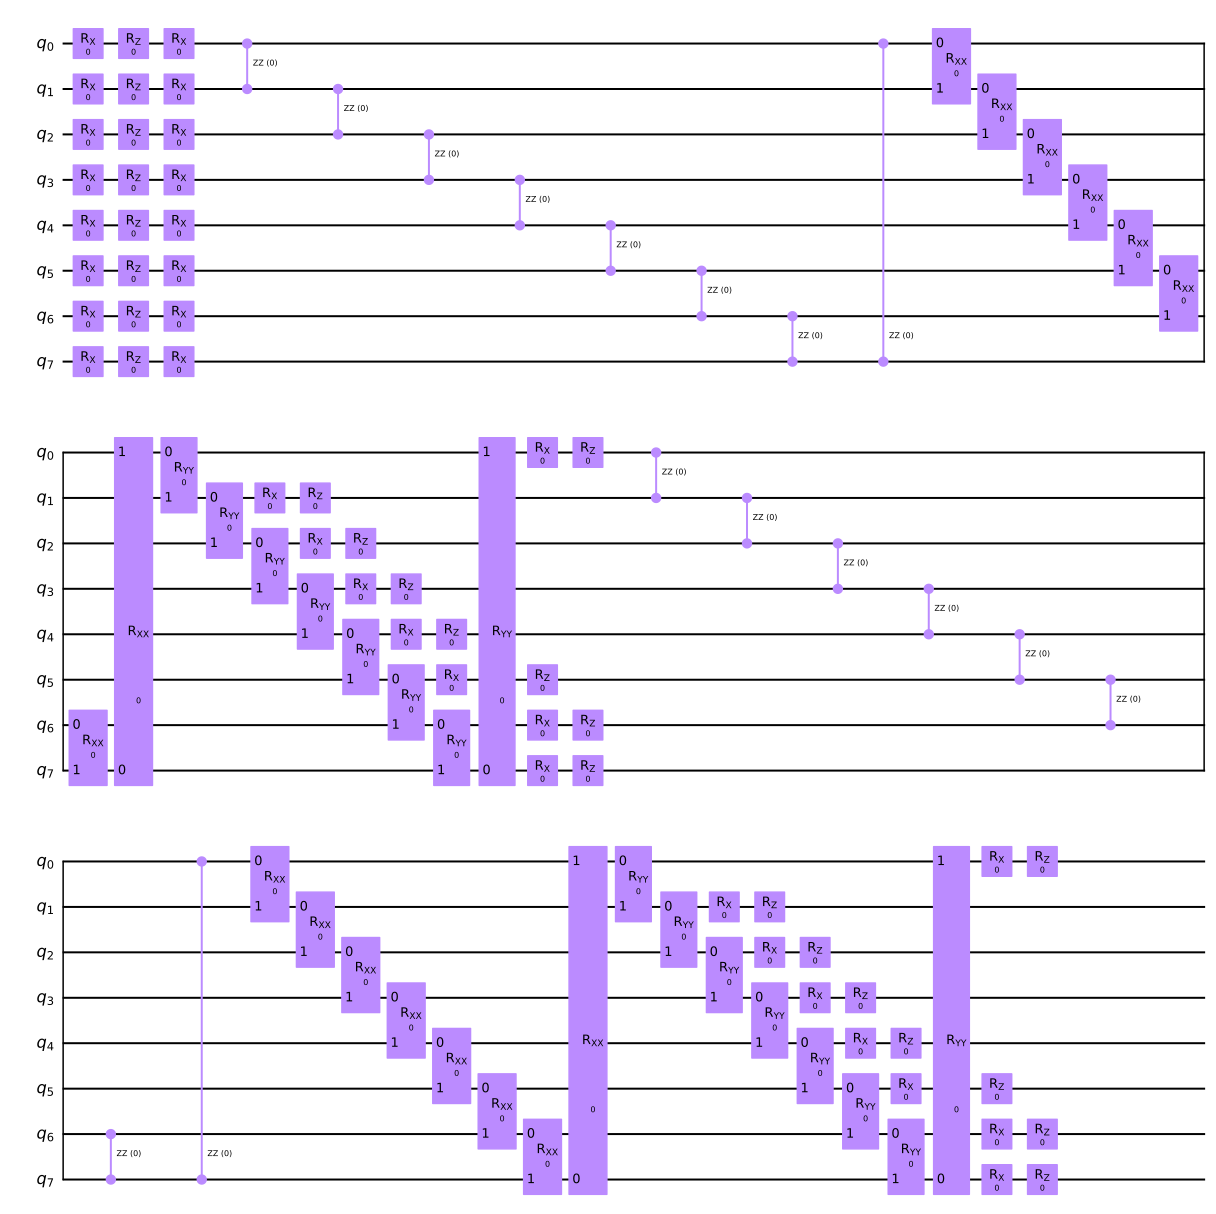

In [6]:
cirq, idx = VQE({"params": np.zeros(3000), "delta": 0.0, "lamb": 0.0}, 8, 2)
print(idx)
cirq.draw()

## NN-VQE

In [6]:
def NN_VQE(n, d, NN_shape: list, stddev):
    input = tf.keras.layers.Input(shape=[2], batch_size=1)  # input layer

    x = tf.keras.layers.Dense(
        units=NN_shape,
        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=stddev),
        activation="ReLU",
    )(input)  # hidden layer

    x = tf.keras.layers.Dropout(0.2)(x)  # dropout layer

    _, idx = VQE(
        {"params": np.zeros(3000), "delta": 0.0, "lamb": 0.0}, n, d, energy_flag=False
    )
    params = tf.keras.layers.Dense(
        units=idx,
        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=stddev),
        activation="sigmoid",
    )(x)  # output layer

    qlayer = tc.KerasLayer(partial(VQE, n=n, d=d, energy_flag=True))  # PQC

    output = qlayer(
        {"params": 6.3 * params[0, :], "delta": input[:, 0], "lamb": input[:, 1]}
    )  # NN-VQE output

    m = tf.keras.Model(inputs=input, outputs=output)

    return m

## Train

In [34]:
def train(n, d, delta, lamb, NN_shape, maxiter=10000, lr=0.005, stddev=1.0):
    exp_lr = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=lr, decay_steps=800, decay_rate=0.7
    )
    opt = tf.keras.optimizers.Adam(exp_lr)  # optimizer

    m = NN_VQE(n, d, NN_shape, stddev)
    for i in range(maxiter):
        with tf.GradientTape() as tape:
            e = tf.zeros([1], dtype=tf.float64)
            for de in delta:  # 1st Hamiltonian parameter
                for la in lamb:  # 2nd Hamiltonian parameter
                    inp = [de, la]
                    e += m(K.reshape(inp, [1, 2]))
        grads = tape.gradient(e, m.variables)
        opt.apply_gradients(zip(grads, m.variables))
        if i % 500 == 0:
            print("epoch", i, ":", e.numpy()[0])
    m.save_weights("NN-VQE.weights.h5")  # save the trained model

In [ ]:
n = 12  # number of qubits
d = 2  # circuit depth
delta = np.linspace(
    -1.0, 1.0, 10, dtype="complex128"
)  # training set of 1st Hamiltonian parameter
lamb = np.linspace(
    0.0, 1.0, 5, dtype="complex128"
)  # training set of 2nd Hamiltonian parameter
NN_shape = 40  # node number of the hidden layer
maxiter = 4000  # maximum iteration for the optimization
lr = 0.01  # learning rate
stddev = 0.1  # the initial standard deviation of the NN

with tf.device("/cpu:0"):
    train(n, d, delta, lamb, NN_shape=NN_shape, maxiter=maxiter, lr=lr, stddev=stddev)

## Test

In [ ]:
# Create test data
test_delta = np.linspace(-1.5, 1.5, 151)  # test set of 1st Hamiltonian parameter
test_lamb = np.linspace(-0.5, 1.5, 101)  # test set of 2nd Hamiltonian parameter
test_energies = np.zeros((151, 101))
m = NN_VQE(n, d, NN_shape, stddev)
m.load_weights("NN-VQE.weights.h5")
for i, de in tqdm(enumerate(test_delta)):
    for j, la in tqdm(enumerate(test_lamb)):
        inp = [de, la]
        test_energies[i, j] = m(K.reshape(inp, [1, 2]))

In [ ]:
test_delta, test_energies